In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from data_factory.DataLoader import DataLoader
from utils.config import load_config
# evaluation file
from utils.evaluation import label_evaluation

sys.path.append('/media/cyprien/Data/Documents/Github/pytorch-forecasting')



In [2]:
config_file = "../config/config.yml"
config = load_config(config_file)

result_file = '../predict.csv'
truth_file = '../ground_truth.hdf'

In [3]:
dl = DataLoader(use_previous_files=True, config_file=config_file)

INFO:data_factory.DataLoader:Use previously generated file ../data//data_export_train.csv_test.csv_fmd-True_False_True_True_0.95.p. Can not redo preprocessing by loading from generated file.


## Feature Engineering

In [4]:
max_prediction_length = 1
max_encoder_length = config['AnomalyTransformer']['max_seq_len']
min_encoder_length = config['AnomalyTransformer']['min_seq_len']


In [5]:
from pytorch_forecasting import TimeSeriesDataSet

X_cols = ['value_scaled', 'kpi_id', 'timestamp_1', 'authentic', 'label']
X_cols_test = ['value_scaled', 'kpi_id', 'timestamp_1', 'authentic']

training = TimeSeriesDataSet(
    dl.train.loc[:, X_cols],
    time_idx='timestamp_1', target='label',
    group_ids=['kpi_id'],
    allow_missing_timesteps=False,
    static_categoricals=['kpi_id', 'authentic'],
    time_varying_unknown_reals=['value_scaled', 'label'],
    # time_varying_known_reals=['timestamp_1'],
    max_encoder_length=max_encoder_length,
    min_encoder_length=min_encoder_length,
    max_prediction_length=max_prediction_length,
    scalers={col: None for col in ['timestamp_1', 'kpi_id', 'value_scaled']},
    target_normalizer=None,
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
)

validation = TimeSeriesDataSet.from_dataset(
    training, dl.val.loc[:, X_cols], stop_randomization=True, predict=False
)
testing = TimeSeriesDataSet.from_dataset(
    training, dl.test.loc[:, X_cols_test], stop_randomization=True, predict=False, min_encoder_length=max_encoder_length,
    target='value_scaled',
    scalers={col: None for col in ['timestamp_1', 'kpi_id']},
    time_varying_unknown_reals=['value_scaled'],

)

In [6]:
batch_size = 64

training_dl = training.to_dataloader(train=True, batch_size=batch_size, num_workers=12)

validation_dl = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=12)
testing_dl = testing.to_dataloader(train=False, batch_size=batch_size * 3, num_workers=12)


## Model

In [7]:
from models.AnomalyTransformer.AnomalyTransformer import AnomalyTransformer

In [8]:
use_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
print("Using", device)
n_features = 1

Using cpu


In [10]:
# for X, (y, _) in training_dl:
#     X_values = X['encoder_cont'][:, :, :1]
#     print(X_values.shape)
#     y_values = X['encoder_cont'][:, :, 1:2]
#     print(y_values.shape)
#     filter_ = X['encoder_cat'].to(torch.bool)[:, :, :1]


In [11]:

from tqdm import tqdm

args = dict(
    win_size=max_encoder_length, enc_in=n_features, c_out=1,
    d_model=256, n_heads=4, e_layers=2, d_ff=256,
    dropout=0.0, activation='gelu', output_attention=True
)

model = AnomalyTransformer(**args)

# model = AnomalyTransformer.load_from_checkpoint("././lightning_logs/version_83887_transformer/checkpoints/epoch=8-step=371448.ckpt", **args)



INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp7e23luxc
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp7e23luxc/_remote_module_non_sriptable.py


In [12]:
from pytorch_lightning.trainer import Trainer

trainer = Trainer(logger=True, enable_checkpointing=True, checkpoint_callback=None, gpus=1 if device == 'cuda' else 0,
                  auto_lr_find=True, max_epochs=-1)

trainer.validate(model=model, dataloaders=validation_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [13]:
trainer.fit(model=model, train_dataloaders=training_dl, val_dataloaders=validation_dl)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type          | Params
---------------------------------------------
0 | embedding  | DataEmbedding | 768   
1 | encoder    | Encoder       | 795 K 
2 | projection | Linear        | 257   
---------------------------------------------
796 K     Trainable params
0         Non-trainable params
796 K     Total params
3.185     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [14]:
trainer.validate(model=model, dataloaders=validation_dl)

# trainer.test(model)
# trainer.predict(model)

Validation: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cyprien/anacon

## Predict abnormal value

In [16]:
from tqdm.notebook import tqdm

def predict_value(df: pd.DataFrame):
    df['timestamp_1_floor'] = df.groupby('kpi_id').timestamp_1.transform(lambda x: x - x.min())
    pv = pd.pivot_table(df, values='value_scaled', index='timestamp_1_floor', columns='kpi_id', fill_value=np.nan)

    ept = np.empty(max_encoder_length)
    ept[:] = np.nan

    pv = pd.concat([pv, pd.DataFrame({col: ept.copy() for col in pv.columns})])

    pv_forward = np.moveaxis(pv.copy().to_numpy(dtype=np.float32), 1, 0)
    pv_filter = np.moveaxis(pv.copy().to_numpy(), 1, 0)
    pv_forward[np.isnan(pv_forward)] = 0
    pv_filter = np.where(np.isnan(pv_filter), 0, 1)

    df['label_pred'] = np.nan

    for i in tqdm(np.arange(0, pv.index.max() + 1, max_encoder_length)):
        pv_forward_i = pv_forward[:, i:i + max_encoder_length]
        pv_filter_i = pv_filter[:, i:i + max_encoder_length]

        X = torch.from_numpy(pv_forward_i.copy())
        X = X.reshape(X.shape[0], X.shape[1], 1)

        y_pred, _, _, _ = model(X)

        validation_filter = df.groupby('kpi_id').apply(
            lambda x: (x.timestamp_1_floor >= i) & (x.timestamp_1_floor < i + max_encoder_length)).reset_index(
            drop=True)

        df.loc[validation_filter, 'label_pred'] = y_pred.cpu().detach().numpy()[pv_filter_i.astype(bool)].flatten()


predict_value(dl.train)
predict_value(dl.test)

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/371 [00:00<?, ?it/s]

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/py

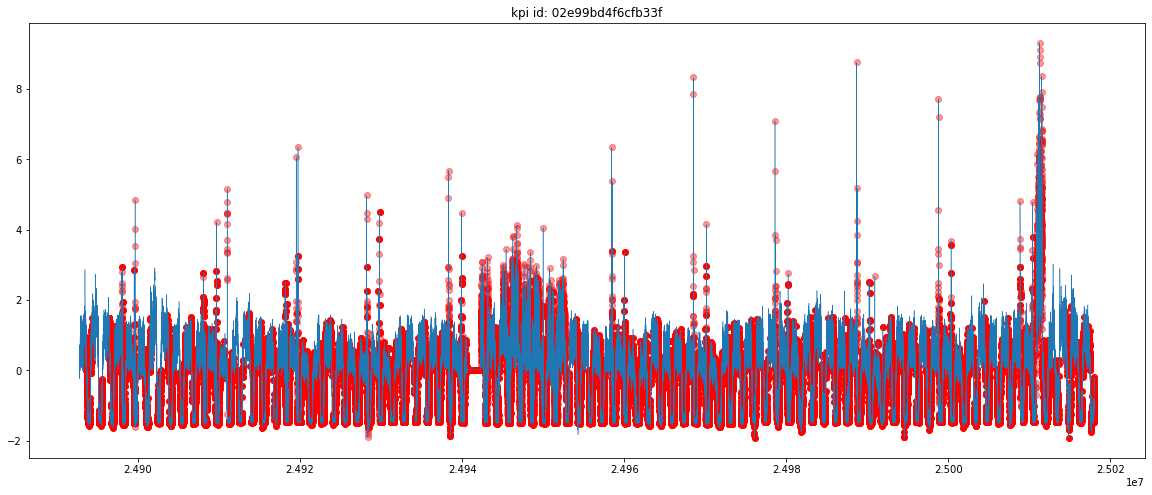

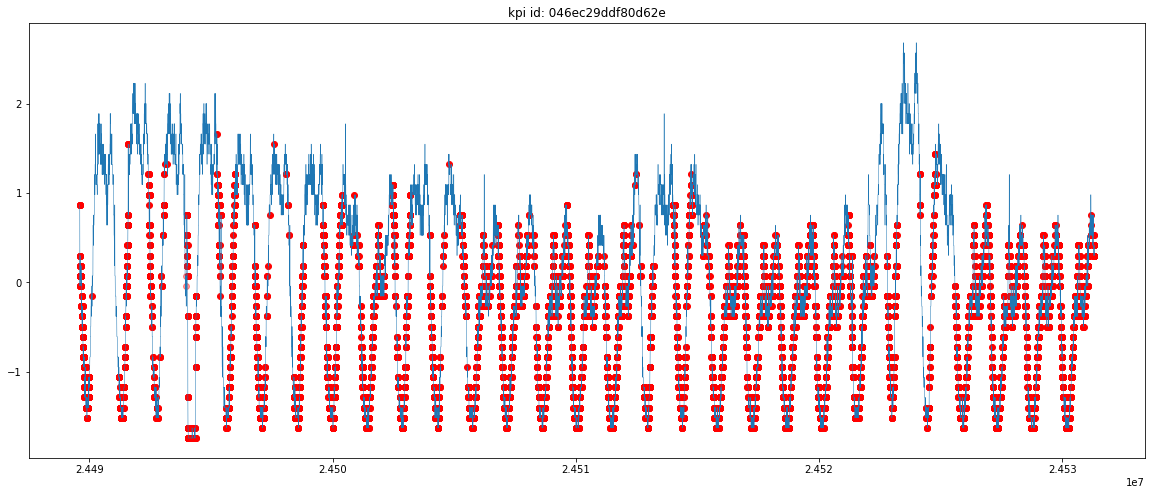

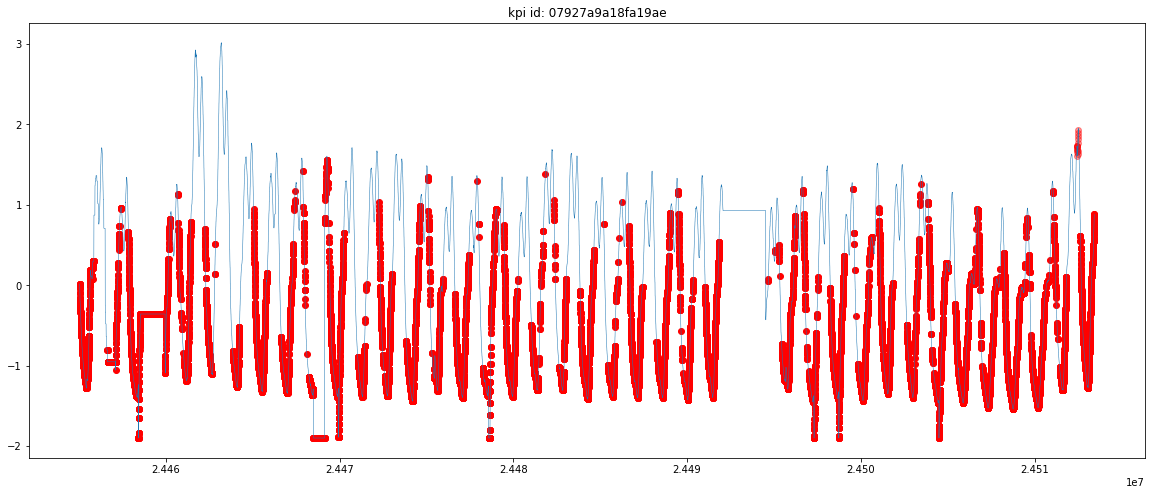

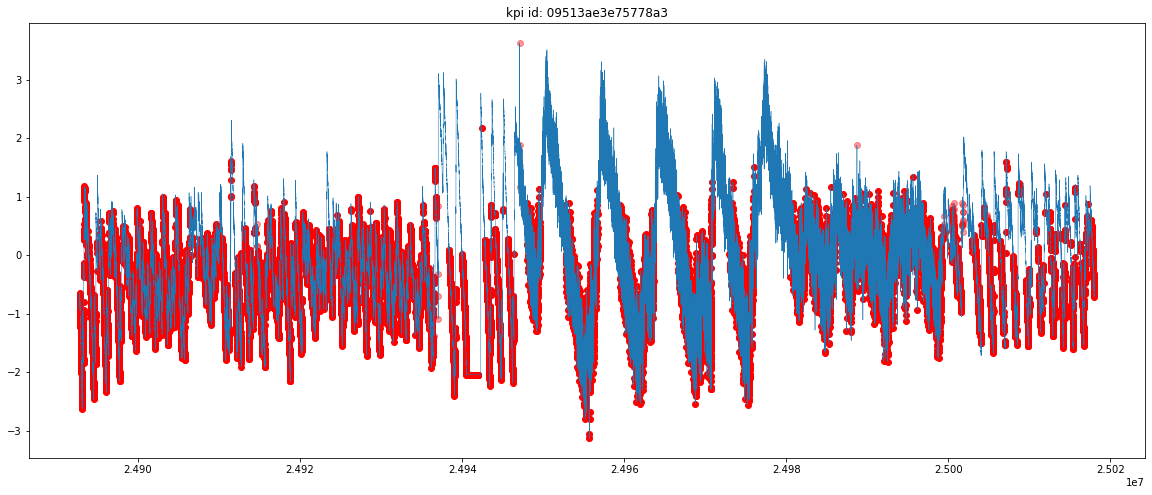

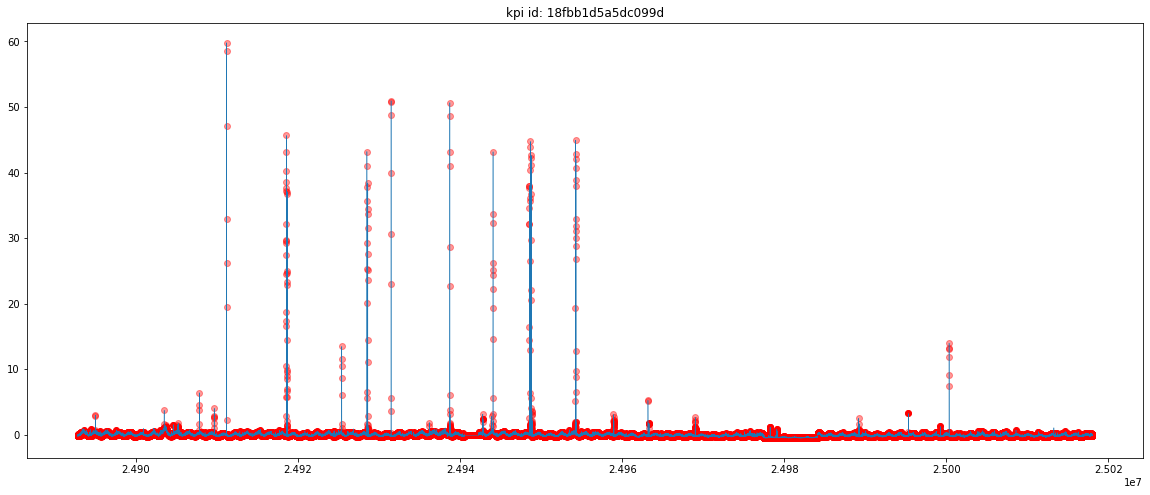

In [17]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

THRESHOLD = .5

for kpi_id in dl.train.kpi_id.unique()[:5]:
    df = dl.train[(dl.train.kpi_id == kpi_id)]

    true_positive = (df.label == 1)

    figure = plt.figure(figsize=(20, 8))
    plt.scatter(df[true_positive].timestamp_1, df[true_positive].value_scaled, c='r', alpha=.4)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5, label='true')
    plt.scatter(df[df.label_pred > THRESHOLD].timestamp_1, df[df.label_pred > THRESHOLD].value_scaled, figure=figure, color='r', label='pred')
    plt.title(f'kpi id: {kpi_id}')
    plt.show()


In [ ]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

for kpi_id in dl.test.kpi_id.unique()[:5]:
    df = dl.test[(dl.test.kpi_id == kpi_id)]

    figure = plt.figure(figsize=(20, 4))

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5)
    plt.title(f'kpi id: {kpi_id}')
    plt.show()


In [ ]:
def predict_label(df: pd.DataFrame):

    df['label_pred'] = np.nan

    for kpi_id in tqdm(df.kpi_id.unique()):
        THRESHOLD = np.abs(df[(df.kpi_id == kpi_id)].value_pred - df[(df.kpi_id == kpi_id)].value_scaled).quantile(.991)
        df.loc[(df.kpi_id == kpi_id), 'label_pred'] = np.abs(
            df[(df.kpi_id == kpi_id)].value_pred -
            df[(df.kpi_id == kpi_id)].value_scaled) > THRESHOLD


predict_label(dl.train)
predict_label(dl.test)

### Training

In [ ]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

for kpi_id in dl.train.kpi_id.unique()[:3]:
    df = dl.train[(dl.train.kpi_id == kpi_id) & (~validation_filter)]

    figure = plt.figure(figsize=(20, 4))
    plt.hist(np.abs(df.value_pred - df.value_scaled), bins=200, figure=figure)

    true_positive = ((df.label == 1) & (df.label_pred == 1))
    false_positive = ((df.label == 0) & (df.label_pred == 1))
    false_negative = ((df.label == 1) & (df.label_pred == 0))

    figure = plt.figure(figsize=(20, 8))
    for filter, color in zip([true_positive, false_positive, false_negative], ['g', 'orange', 'r']):
        plt.scatter(df[filter].timestamp_1, df[filter].value_scaled, c=color, alpha=.4)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5)
    plt.title(f'kpi id: {kpi_id}')
    plt.show()


In [ ]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

for kpi_id in dl.train.kpi_id.unique()[:3]:
    df = dl.train[(dl.train.kpi_id == kpi_id) & (validation_filter)]

    figure = plt.figure(figsize=(20, 4))
    plt.hist(np.abs(df.value_pred - df.value_scaled), bins=200, figure=figure)

    true_positive = ((df.label == 1) & (df.label_pred == 1))
    false_positive = ((df.label == 0) & (df.label_pred == 1))
    false_negative = ((df.label == 1) & (df.label_pred == 0))

    figure = plt.figure(figsize=(20, 8))
    for filter, color in zip([true_positive, false_positive, false_negative], ['g', 'orange', 'r']):
        plt.scatter(df[filter].timestamp_1, df[filter].value_scaled, c=color, alpha=.4)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5)
    plt.title(f'kpi id: {kpi_id}')
    plt.show()


## Export

In [ ]:
validation_start_points = normal_train.groupby('kpi_id').apply(
    lambda x: x.timestamp_1.max() - (max_encoder_length + max_prediction_length)).to_frame('limit').to_dict()['limit']
validation_start_points

In [ ]:
validation_filter = dl.train.groupby('kpi_id').apply(
    lambda x: x.timestamp_1 >= validation_start_points[x.kpi_id.iloc[0]]).reset_index(
    drop=True)

In [ ]:
prediction = dl.train.loc[validation_filter  & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred']
prediction.to_csv(result_file)

ground_truth = dl.train.loc[validation_filter & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label']].rename(columns={'kpi_id': 'KPI ID'})
ground_truth.to_hdf(truth_file, key='df')

print(label_evaluation(truth_file, result_file))

In [ ]:
prediction = dl.train.loc[~validation_filter & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred']
prediction.to_csv(result_file)

ground_truth = dl.train.loc[~validation_filter & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label']].rename(columns={'kpi_id': 'KPI ID'})
ground_truth.to_hdf(truth_file, key='df')

print(label_evaluation(truth_file, result_file))

.997: .2791
.995: .4579
.993: .4628
.992: .5719
.991: .5609
.990: .5525
.989: .5521
.985: .5469

In [ ]:
prediction = dl.test.loc[dl.test.authentic == 'True', ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred'].astype(int)
prediction.drop(columns=['label_pred'], inplace=True)
prediction.to_csv(result_file)

### Plot

In [ ]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

for kpi_id in dl.test.kpi_id.unique()[:10]:
    df = dl.test[(dl.test.kpi_id == kpi_id) & (dl.test.authentic == 'True')]

    figure = plt.figure(figsize=(20, 4))
    plt.hist(np.abs(df.value_pred - df.value_scaled), bins=200, figure=figure)
    plt.show()

    figure = plt.figure(figsize=(20, 4))

    plt.scatter(df[df.label_pred == 1].timestamp_1, df[df.label_pred == 1].value_scaled, c='r', alpha=.4)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5)
    plt.title(f'kpi id: {kpi_id}')
    plt.show()